In [ ]:
# import matplotlib.pyplot as plt
# plt.bar([1,2,3,4,5,6,7,8,9,10],[0.018451246403640677,0.01618125536855392,0.026755434746750142,0.02452559313533195,0.02044580782769432,0.017003597109502003,0.020559589203612224,0.019298891636764515,0.020253734759057913,0.0211521205231758])
# plt.title("Relative Eigen Error (REE) for 10 different initialization of C")

In [8]:
name="MUTAG"
num_features=7
num_classes=2
train_size=int(0.8*188)
A_max_size=28
graph_size=188

In [9]:

# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name=name)
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

2.0.1

Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


This dataset provides **188 different graphs**, and the task is to classify each graph into **one out of two classes**.

By inspecting the first graph object of the dataset, we can see that it comes with **17 nodes (with 7-dimensional feature vectors)** and **38 edges** (leading to an average node degree of 2.24).
It also comes with exactly **one graph label** (`y=[1]`), and, in addition to previous datasets, provides addtional **4-dimensional edge features** (`edge_attr=[38, 4]`).
However, for the sake of simplicity, we will not make use of those.

PyTorch Geometric provides some useful utilities for working with graph datasets, *e.g.*, we can shuffle the dataset and use the first 150 graphs as training graphs, while using the remaining ones for testing:

In [11]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:train_size]
test_dataset = dataset[train_size:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


MUTAG

In [12]:

!pip install networkx
!pip install dgl
!pip install torch


In [13]:

import torch


from sklearn.model_selection import train_test_split
import pandas as pd
import csv

In [14]:
from itertools import product
import time
import argparse
from datasets import get_dataset
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore")

# from coarsening_opt2 import MultiLayerCoarsening
import torch
import os
from torch_geometric.data import DataLoader, DenseDataLoader as DenseLoader
from torch.optim import Adam
# from train_eval_opt import cross_validation_with_val_set_opt, getMiddleRes

ImportError: cannot import name 'get_dataset' from 'datasets' (/Users/prakashpal/anaconda3/lib/python3.11/site-packages/datasets/__init__.py)

In [15]:
# from datasets import get_dataset

In [16]:

from tqdm import tqdm

Building the dataset

In [17]:
dataset = get_dataset(name,sparse=False, dirname=None)

NameError: name 'get_dataset' is not defined

In [ ]:

print(dataset)


MUTAG(188)


In [ ]:
dataset[1]

Data(x=[28, 7], y=[1], adj=[28, 28], mask=[28])

In [ ]:
dataset[2]

Data(x=[28, 7], y=[1], adj=[28, 28], mask=[28])

In [ ]:
dataset[1].adj

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  

In [ ]:
class Graph:
  def __init__(self,x,adj,y):
      self.x = x
      self.adj = adj
      self.y = y


In [ ]:

data = []

In [ ]:
for matrix in range(graph_size):
  last_row =  A_max_size
  for i in range(A_max_size-1,-1,-1):
    if(torch.sum(dataset[matrix].adj[i,:])==0 and torch.sum(dataset[matrix].adj[:,i])==0):
      last_row = i
    else:
      break
  # print(last_row)
  temp_adj = dataset[matrix].adj[:last_row,:last_row]
  temp_x = dataset[matrix].x[:last_row,:]
  temp_y = dataset[matrix].y
  temp_graph = Graph(temp_x,temp_adj,temp_y)
  data.append(temp_graph)

print(dataset[0].adj.shape)
temp = dataset[-1].adj[:last_row,:last_row]
print(temp.shape)

torch.Size([28, 28])
torch.Size([16, 16])


In [ ]:
data[0].adj.shape

torch.Size([17, 17])

In [ ]:
data[1].adj.shape

torch.Size([13, 13])

Applying FGC to coarsen the data

In [ ]:
adj = data[1].adj
X = data[1].x

In [ ]:
def get_laplacian(adj):
  adj=np.array(adj)
  b=np.ones(adj.shape[0])
  z=adj@b
  D=np.diag(z)
  L=D-adj
  return torch.Tensor(L)
# def get_laplacian(adj):
#   theta = torch.eye(adj.shape[0])
#   row_sum = torch.sum(adj,axis=1)
#   theta = theta@row_sum - adj
#   return theta

In [ ]:
theta = get_laplacian(adj)

In [ ]:
X.shape,theta.shape

(torch.Size([13, 7]), torch.Size([13, 13]))

In [ ]:
def convertScipyToTensor(coo):
  try:
    coo = coo.tocoo()
  except:
    coo = coo
  values = coo.data
  indices = np.vstack((coo.row, coo.col))

  i = torch.LongTensor(indices)
  v = torch.FloatTensor(values)
  shape = coo.shape

  return torch.sparse.FloatTensor(i, v, torch.Size(shape))

In [ ]:
from scipy.sparse import random
from scipy.sparse.linalg import norm
from scipy.sparse import csr_matrix

p = X.shape[0]
k = p//2
n = X.shape[1]
lambda_param = 20
beta_param = 1
alpha_param = 10
gamma_param = 25
lr = 1e-5
thresh = 1e-10

from scipy.sparse import random
from scipy.stats import rv_continuous
class CustomDistribution(rv_continuous):
    def _rvs(self,  size=None, random_state=None):
        return random_state.standard_normal(size)
temp = CustomDistribution(seed=1)
temp2 = temp()  # get a frozen version of the distribution
X_tilde = random(k, n, density=0.25, random_state=1, data_rvs=temp2.rvs)
C = random(p, k, density=0.25, random_state=1, data_rvs=temp2.rvs)

In [ ]:
def experiment(lambda_param,beta_param,alpha_param,gamma_param,C,X_tilde,theta,X):
      p = X.shape[0]
      k = p//2
      n = X.shape[1]
      ones = csr_matrix(np.ones((k,k)))
      ones = convertScipyToTensor(ones)
      ones = ones.to_dense()
      J = np.outer(np.ones(k), np.ones(k))/k
      J = csr_matrix(J)
      J = convertScipyToTensor(J)
      J = J.to_dense()
      zeros = csr_matrix(np.zeros((p,k)))
      zeros = convertScipyToTensor(zeros)
      zeros = zeros.to_dense()
      X_tilde = convertScipyToTensor(X_tilde)
      X_tilde = X_tilde.to_dense()
      C = convertScipyToTensor(C)
      C = C.to_dense()
      try:
        theta = convertScipyToTensor(theta)
      except:
        theta = theta
      try:
        X = convertScipyToTensor(X)
        X = X.to_dense()
      except:
        X = X

      if(torch.cuda.is_available()):
        print("yes")
        X_tilde = X_tilde.cuda()
        C = C.cuda()
        theta = theta.cuda()
        X = X.cuda()
        J = J.cuda()
        zeros = zeros.cuda()
        ones = ones.cuda()

      def update(X_tilde,C,i):
          global L
          thetaC = theta@C
          CT = torch.transpose(C,0,1)
          X_tildeT = torch.transpose(X_tilde,0,1)
          CX_tilde = C@X_tilde
          t1 = CT@thetaC + J
          term_bracket = torch.linalg.pinv(t1)
          thetacX_tilde = thetaC@(X_tilde)

          L = 1/k

          t1 = -2*gamma_param*(thetaC@term_bracket)
          t2 = alpha_param*(CX_tilde-X)@(X_tildeT)
          t3 = 2*thetacX_tilde@(X_tildeT)
          t4 = lambda_param*(C@ones)
          t5 = 2*beta_param*(thetaC@CT@thetaC)
          T2 = (t1+t2+t3+t4+t5)/L
          Cnew = (C-T2).maximum(zeros)
          t1 = CT@thetaC*(2/alpha_param)
          t2 = CT@C
          t1 = torch.linalg.pinv(t1+t2)
          t1 = t1@CT
          t1 = t1@X
          X_tilde_new = t1
          Cnew[Cnew<thresh] = thresh
          for i in range(len(Cnew)):
              Cnew[i] = Cnew[i]/torch.linalg.norm(Cnew[i],1)
          for i in range(len(X_tilde_new)):
            X_tilde_new[i] = X_tilde_new[i]/torch.linalg.norm(X_tilde_new[i],1)
          return X_tilde_new,Cnew


      for i in tqdm(range(100)):
          X_tilde,C = update(X_tilde,C,i)

      return X_tilde,C

In [ ]:
import matplotlib.pyplot as plt


100%|██████████| 100/100 [00:00<00:00, 627.57it/s]


50 1 50 100
 eigen_error 
(0.10772111980865398+0j)


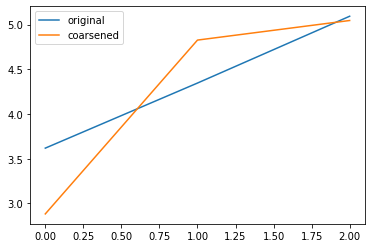

tensor(2.7112)
tensor(10.)
tensor(2.7021)


In [ ]:
for lambda_param in [50]:
  for beta_param in [1]:
    for alpha_param in [50]:
      for gamma_param in [100]:

          X_t_0,C_0 = experiment(lambda_param,beta_param,alpha_param,gamma_param,C,X_tilde,theta,X)
          print(str(lambda_param)+" " + str(beta_param)+" "+str(alpha_param)+" "+str(gamma_param))

          L = theta
          eigen_values,eigenvectors=torch.linalg.eig(L)
          eigen_values = eigen_values.cpu().detach().numpy()
          s=np.sort(eigen_values)

          eigen_value,eigenvector=torch.linalg.eig(C_0.T@L@C_0)
          eigen_value = eigen_value.cpu().detach().numpy()
          z=np.sort(eigen_value)


          s_new=s[-3:]
          z_new=z[-3:]

          temp=0
          for j in range(len(s_new)):
            temp=temp+(abs(z_new[j]-s_new[j])/s_new[j])
          eigenerror=temp/len(s_new)
          print(" eigen_error ")
          print(eigenerror)

          plt.plot(s_new, label="original")
          plt.plot(z_new, label="coarsened")
          plt.legend()
          plt.show()

          print(torch.trace(X_t_0.T@C_0.T@L@C_0@X_t_0))
          print(torch.trace(X.T@L@X))
          error=torch.linalg.norm(X-(C_0@X_t_0))
          print(error)

In [ ]:
Lc=C_0.T@L@C_0
print("Lc",Lc)
Wc=(-1*Lc)*(1-np.eye(Lc.shape[0]))
Wc[Wc<0.001]=0
print("Wc",Wc)
print((Wc!=0).sum()/2)
print((adj!=0).sum()/2)

Lc tensor([[ 0.1389,  0.0786, -0.2127, -0.1306,  0.1389, -0.0131],
        [ 0.0786,  2.6415, -1.5243, -0.3568,  0.0786, -0.9176],
        [-0.2127, -1.5243,  3.6672, -0.7975, -0.2127, -0.9200],
        [-0.1306, -0.3568, -0.7975,  3.0490, -0.1306, -1.6335],
        [ 0.1389,  0.0786, -0.2127, -0.1306,  0.1389, -0.0131],
        [-0.0131, -0.9176, -0.9200, -1.6335, -0.0131,  3.4973]])
Wc tensor([[0.0000, 0.0000, 0.2127, 0.1306, 0.0000, 0.0131],
        [0.0000, 0.0000, 1.5243, 0.3568, 0.0000, 0.9176],
        [0.2127, 1.5243, 0.0000, 0.7975, 0.2127, 0.9200],
        [0.1306, 0.3568, 0.7975, 0.0000, 0.1306, 1.6335],
        [0.0000, 0.0000, 0.2127, 0.1306, 0.0000, 0.0131],
        [0.0131, 0.9176, 0.9200, 1.6335, 0.0131, 0.0000]], dtype=torch.float64)
tensor(12.)
tensor(14.)


In [ ]:
print(X.shape)

torch.Size([13, 7])


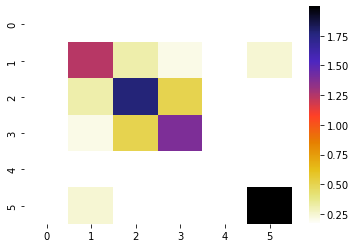

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
# sns.heatmap(C_0.T@C_0)
temp = C_0.T.cpu().detach().numpy()
temp1 = C_0.cpu().detach().numpy()
a = sns.heatmap(temp@temp1,cmap='CMRmap_r')

In [ ]:
train_data_coarsened = []

In [ ]:
def get_coarsened_features(X,adj):

    theta = get_laplacian(adj)

    p = X.shape[0]
    k = p//2
    n = X.shape[1]
    lambda_param = 50
    beta_param = 10
    alpha_param = 50
    gamma_param = 100
    lr = 1e-5
    thresh = 1e-10

    from scipy.sparse import random
    from scipy.stats import rv_continuous
    class CustomDistribution(rv_continuous):
        def _rvs(self,  size=None, random_state=None):
            return random_state.standard_normal(size)
    temp = CustomDistribution(seed=1)
    temp2 = temp()  # get a frozen version of the distribution
    X_tilde = random(k, n, density=0.25, random_state=1, data_rvs=temp2.rvs)
    C = random(p, k, density=0.25, random_state=1, data_rvs=temp2.rvs)

    try:
      X_t_0,C_0 = experiment(100,1,100,1000,C,X_tilde,theta,X)
    except:
      try:
        X_t_0,C_0 = experiment(100,1,100,1000,C,X_tilde,theta,X)
      except:
        try:
          X_t_0,C_0 = experiment(100,1,100,1000,C,X_tilde,theta,X)
        except:
          X_t_0,C_0 = convertScipyToTensor(X_tilde).to_dense(),convertScipyToTensor(C).to_dense()


    print("X_t_0 shape :",X_t_0.shape)
    print("C_0 shape :", C_0.shape)
    thetaC = (C_0.T)@theta@C_0
    print("thetaC shape :", thetaC.shape)

    print(thetaC.shape)
    print(X_tilde.shape)
    # return thetaC, X_tilde
    target_theta = torch.zeros(A_max_size,A_max_size)
    print("target_theta_original shape :", target_theta.shape)
    target_X = torch.zeros(A_max_size,num_features)
    print("target_X_original shape :", target_X.shape)



    shape1 = thetaC.shape[0]
    target_theta[:shape1,:shape1]=thetaC
    shape1 = X_t_0.shape[0]
    target_X[:shape1,:]=X_t_0

    target_theta = target_theta.flatten()
    print("target_theta_flatten shape:", target_theta.shape)
    target_X = target_X.flatten()
    print("target_X_flatten shape:", target_X.shape)

    feature_vec = torch.concat((target_X,target_theta),0)
    print("final_feature_vec shape:", feature_vec.shape)

    return feature_vec




In [ ]:
from datetime import datetime

In [ ]:
# time1=datetime.now()
# X_List=[]
# W_List=[]
# D_INV_List=[]
# Node_Size=[]
# Y=[]
# EE=[]
# for i in range(graph_size):
#   Lc,Xc=get_coarsened_features(data[i].x,data[i].adj)
#   Wc=(-1*Lc)*(1-np.eye(Lc.shape[0]))
#   Wc[Wc<0.01]=0
#   import numpy as np
#   bb=np.ones(Wc.shape[0])
#   zz=Wc@bb
#   Dc=np.linalg.pinv(np.diag(zz))
#   Node_Size+=[Xc.shape[0]]
#   Y+=[int(data[i].y)]
#   D_INV_List+=[Dc]
#   W_List+=[Wc]
#   X_List+=[Xc.toarray()]
#   L=get_laplacian(data[i].adj)
#   eigen_values,eigenvectors=torch.linalg.eig(L)
#   eigen_values = eigen_values.cpu().detach().numpy()
#   s=np.sort(eigen_values)

#   eigen_value,eigenvector=torch.linalg.eig(Lc)
#   eigen_value = eigen_value.cpu().detach().numpy()
#   z=np.sort(eigen_value)
#   if(Lc.shape[0]<3):
#     s_new=s[-2:]
#     z_new=z[-2:]
#     temp=0
#     for j in range(len(s_new)):
#       temp=temp+(abs(z_new[j]-s_new[j])/s_new[j])
#     eigenerror=temp/len(s_new)
#     EE+=[eigenerror]
#   else:
#     s_new=s[-3:]
#     z_new=z[-3:]

#     temp=0
#     for j in range(len(s_new)):
#       temp=temp+(abs(z_new[j]-s_new[j])/s_new[j])
#     eigenerror=temp/len(s_new)
#     EE+=[eigenerror]
# time2=datetime.now()
# print((time2-time1).total_seconds())


In [ ]:
# sum(EE)/graph_size

In [ ]:
# EE



In [ ]:
# sum(np.sort(EE)[0:4000])/4000

In [ ]:
# from gnn import split_train_test, train

In [ ]:
#  D_inverse_train, D_inverse_test, A_tilde_train, A_tilde_test, X_train, X_test, Y_train, Y_test, nodes_size_list_train, nodes_size_list_test = split_train_test(np.array(D_INV_List), np.array(W_List), np.array(X_List), np.array(Y).reshape((graph_size,1)), np.array(Node_Size))


In [ ]:
# np.array(X_List)[0]

In [ ]:
# np.array(Y).reshape((188,1))

In [ ]:
# time1=datetime.now()
# test_acc, prediction, pos_scores = train(X_train, D_inverse_train, A_tilde_train, Y_train, nodes_size_list_train,X_test, D_inverse_test, A_tilde_test, Y_test, nodes_size_list_test,60, num_features,0.00001,100, name)
# print("test acc is ", test_acc)
# time2=datetime.now()
# print('time ',(time2-time1).total_seconds())

In [ ]:
from datetime import datetime

In [ ]:
# name="IMDB-BINARY"
# num_features=136
# num_classes=2
# train_size=int(0.8*999)
# A_max_size=98
# graph_size=999

In [ ]:
# print((time2-time1).total_seconds())

In [ ]:
dataset
#

MUTAG(188)

In [ ]:
t = get_coarsened_features(data[0].x,data[0].adj)

100%|██████████| 100/100 [00:00<00:00, 1065.15it/s]

X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([17, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


In [ ]:
time1=datetime.now()
for i in range(graph_size):
    tdc = get_coarsened_features(data[i].x,data[i].adj)
    train_data_coarsened.append(tdc)
train_X = torch.stack(train_data_coarsened)
print(train_X.shape)
time2=datetime.now()
print((time2-time1).total_seconds())

100%|██████████| 100/100 [00:00<00:00, 1212.41it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([17, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1162.30it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([13, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1444.99it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([13, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1149.00it/s]


X_t_0 shape : torch.Size([9, 7])
C_0 shape : torch.Size([19, 9])
thetaC shape : torch.Size([9, 9])
torch.Size([9, 9])
(9, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1366.50it/s]


X_t_0 shape : torch.Size([5, 7])
C_0 shape : torch.Size([11, 5])
thetaC shape : torch.Size([5, 5])
torch.Size([5, 5])
(5, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 760.99it/s]


X_t_0 shape : torch.Size([14, 7])
C_0 shape : torch.Size([28, 14])
thetaC shape : torch.Size([14, 14])
torch.Size([14, 14])
(14, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1270.63it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([16, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 873.43it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([20, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1392.21it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([12, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1214.34it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([17, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1134.82it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([17, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1093.25it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([20, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 940.17it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([22, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1360.96it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([13, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1078.07it/s]


X_t_0 shape : torch.Size([9, 7])
C_0 shape : torch.Size([19, 9])
thetaC shape : torch.Size([9, 9])
torch.Size([9, 9])
(9, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 957.88it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([22, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1313.83it/s]


X_t_0 shape : torch.Size([5, 7])
C_0 shape : torch.Size([11, 5])
thetaC shape : torch.Size([5, 5])
torch.Size([5, 5])
(5, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1218.22it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([17, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1385.99it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([13, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1170.29it/s]


X_t_0 shape : torch.Size([9, 7])
C_0 shape : torch.Size([18, 9])
thetaC shape : torch.Size([9, 9])
torch.Size([9, 9])
(9, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 754.48it/s]


X_t_0 shape : torch.Size([9, 7])
C_0 shape : torch.Size([18, 9])
thetaC shape : torch.Size([9, 9])
torch.Size([9, 9])
(9, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 725.02it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([17, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 606.06it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([23, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 735.57it/s]


X_t_0 shape : torch.Size([13, 7])
C_0 shape : torch.Size([27, 13])
thetaC shape : torch.Size([13, 13])
torch.Size([13, 13])
(13, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1148.20it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([17, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1328.62it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([13, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1000.76it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([23, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1087.35it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([17, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 901.11it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([23, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 915.44it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([23, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1006.09it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([22, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 850.62it/s]


X_t_0 shape : torch.Size([12, 7])
C_0 shape : torch.Size([24, 12])
thetaC shape : torch.Size([12, 12])
torch.Size([12, 12])
(12, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 919.17it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([23, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1283.59it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([13, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1096.86it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([17, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1321.16it/s]


X_t_0 shape : torch.Size([7, 7])
C_0 shape : torch.Size([14, 7])
thetaC shape : torch.Size([7, 7])
torch.Size([7, 7])
(7, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 707.83it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([17, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


  2%|▏         | 2/100 [00:00<00:01, 94.27it/s]


X_t_0 shape : torch.Size([7, 7])
C_0 shape : torch.Size([15, 7])
thetaC shape : torch.Size([7, 7])
torch.Size([7, 7])
(7, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


  2%|▏         | 2/100 [00:00<00:01, 96.95it/s]


X_t_0 shape : torch.Size([7, 7])
C_0 shape : torch.Size([15, 7])
thetaC shape : torch.Size([7, 7])
torch.Size([7, 7])
(7, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1287.46it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([13, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1159.10it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([17, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1206.64it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([13, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1097.89it/s]


X_t_0 shape : torch.Size([9, 7])
C_0 shape : torch.Size([19, 9])
thetaC shape : torch.Size([9, 9])
torch.Size([9, 9])
(9, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1135.17it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([17, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1191.69it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([12, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 915.09it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([23, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 972.29it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([22, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1162.22it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([17, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 877.42it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([20, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1162.58it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([16, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 844.69it/s]


X_t_0 shape : torch.Size([13, 7])
C_0 shape : torch.Size([26, 13])
thetaC shape : torch.Size([13, 13])
torch.Size([13, 13])
(13, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 858.46it/s]


X_t_0 shape : torch.Size([13, 7])
C_0 shape : torch.Size([26, 13])
thetaC shape : torch.Size([13, 13])
torch.Size([13, 13])
(13, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1004.55it/s]


X_t_0 shape : torch.Size([9, 7])
C_0 shape : torch.Size([19, 9])
thetaC shape : torch.Size([9, 9])
torch.Size([9, 9])
(9, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1086.67it/s]


X_t_0 shape : torch.Size([9, 7])
C_0 shape : torch.Size([19, 9])
thetaC shape : torch.Size([9, 9])
torch.Size([9, 9])
(9, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1254.96it/s]


X_t_0 shape : torch.Size([7, 7])
C_0 shape : torch.Size([14, 7])
thetaC shape : torch.Size([7, 7])
torch.Size([7, 7])
(7, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1119.89it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([17, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 867.77it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([21, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 864.56it/s]


X_t_0 shape : torch.Size([12, 7])
C_0 shape : torch.Size([25, 12])
thetaC shape : torch.Size([12, 12])
torch.Size([12, 12])
(12, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 976.01it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([23, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1000.39it/s]


X_t_0 shape : torch.Size([9, 7])
C_0 shape : torch.Size([19, 9])
thetaC shape : torch.Size([9, 9])
torch.Size([9, 9])
(9, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 921.29it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([17, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 840.31it/s]


X_t_0 shape : torch.Size([5, 7])
C_0 shape : torch.Size([11, 5])
thetaC shape : torch.Size([5, 5])
torch.Size([5, 5])
(5, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 576.06it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([23, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 903.35it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([20, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1106.96it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([16, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1343.75it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([16, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1058.44it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([20, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 966.84it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([23, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1094.07it/s]


X_t_0 shape : torch.Size([9, 7])
C_0 shape : torch.Size([19, 9])
thetaC shape : torch.Size([9, 9])
torch.Size([9, 9])
(9, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1214.55it/s]


X_t_0 shape : torch.Size([7, 7])
C_0 shape : torch.Size([14, 7])
thetaC shape : torch.Size([7, 7])
torch.Size([7, 7])
(7, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 817.89it/s]


X_t_0 shape : torch.Size([13, 7])
C_0 shape : torch.Size([26, 13])
thetaC shape : torch.Size([13, 13])
torch.Size([13, 13])
(13, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1124.79it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([16, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1063.77it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([16, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 869.57it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([23, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 755.45it/s]


X_t_0 shape : torch.Size([9, 7])
C_0 shape : torch.Size([18, 9])
thetaC shape : torch.Size([9, 9])
torch.Size([9, 9])
(9, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1131.20it/s]


X_t_0 shape : torch.Size([5, 7])
C_0 shape : torch.Size([10, 5])
thetaC shape : torch.Size([5, 5])
torch.Size([5, 5])
(5, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1036.20it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([16, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1166.44it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([16, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1119.78it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([17, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 888.50it/s]


X_t_0 shape : torch.Size([9, 7])
C_0 shape : torch.Size([19, 9])
thetaC shape : torch.Size([9, 9])
torch.Size([9, 9])
(9, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1332.70it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([12, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 903.98it/s]


X_t_0 shape : torch.Size([12, 7])
C_0 shape : torch.Size([25, 12])
thetaC shape : torch.Size([12, 12])
torch.Size([12, 12])
(12, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1280.70it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([16, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1348.80it/s]


X_t_0 shape : torch.Size([5, 7])
C_0 shape : torch.Size([11, 5])
thetaC shape : torch.Size([5, 5])
torch.Size([5, 5])
(5, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 820.84it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([23, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 832.19it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([23, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1140.39it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([16, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1218.14it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([12, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1236.46it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([13, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 902.73it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([23, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 785.60it/s]


X_t_0 shape : torch.Size([12, 7])
C_0 shape : torch.Size([25, 12])
thetaC shape : torch.Size([12, 12])
torch.Size([12, 12])
(12, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1053.82it/s]


X_t_0 shape : torch.Size([9, 7])
C_0 shape : torch.Size([19, 9])
thetaC shape : torch.Size([9, 9])
torch.Size([9, 9])
(9, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 861.61it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([23, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1065.21it/s]


X_t_0 shape : torch.Size([9, 7])
C_0 shape : torch.Size([19, 9])
thetaC shape : torch.Size([9, 9])
torch.Size([9, 9])
(9, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1090.36it/s]


X_t_0 shape : torch.Size([9, 7])
C_0 shape : torch.Size([19, 9])
thetaC shape : torch.Size([9, 9])
torch.Size([9, 9])
(9, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 709.02it/s]


X_t_0 shape : torch.Size([12, 7])
C_0 shape : torch.Size([25, 12])
thetaC shape : torch.Size([12, 12])
torch.Size([12, 12])
(12, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1111.16it/s]


X_t_0 shape : torch.Size([9, 7])
C_0 shape : torch.Size([18, 9])
thetaC shape : torch.Size([9, 9])
torch.Size([9, 9])
(9, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1296.03it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([13, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


  2%|▏         | 2/100 [00:00<00:00, 99.07it/s]


X_t_0 shape : torch.Size([7, 7])
C_0 shape : torch.Size([15, 7])
thetaC shape : torch.Size([7, 7])
torch.Size([7, 7])
(7, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1331.97it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([16, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 814.11it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([23, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 794.73it/s]


X_t_0 shape : torch.Size([13, 7])
C_0 shape : torch.Size([26, 13])
thetaC shape : torch.Size([13, 13])
torch.Size([13, 13])
(13, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1055.19it/s]


X_t_0 shape : torch.Size([9, 7])
C_0 shape : torch.Size([19, 9])
thetaC shape : torch.Size([9, 9])
torch.Size([9, 9])
(9, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 806.79it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([23, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1163.31it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([17, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1029.20it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([20, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 831.97it/s]


X_t_0 shape : torch.Size([12, 7])
C_0 shape : torch.Size([25, 12])
thetaC shape : torch.Size([12, 12])
torch.Size([12, 12])
(12, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1037.40it/s]


X_t_0 shape : torch.Size([9, 7])
C_0 shape : torch.Size([19, 9])
thetaC shape : torch.Size([9, 9])
torch.Size([9, 9])
(9, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 750.07it/s]


X_t_0 shape : torch.Size([14, 7])
C_0 shape : torch.Size([28, 14])
thetaC shape : torch.Size([14, 14])
torch.Size([14, 14])
(14, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 904.42it/s]


X_t_0 shape : torch.Size([12, 7])
C_0 shape : torch.Size([24, 12])
thetaC shape : torch.Size([12, 12])
torch.Size([12, 12])
(12, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1510.22it/s]


X_t_0 shape : torch.Size([5, 7])
C_0 shape : torch.Size([11, 5])
thetaC shape : torch.Size([5, 5])
torch.Size([5, 5])
(5, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


  2%|▏         | 2/100 [00:00<00:01, 88.58it/s]


X_t_0 shape : torch.Size([7, 7])
C_0 shape : torch.Size([15, 7])
thetaC shape : torch.Size([7, 7])
torch.Size([7, 7])
(7, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1342.49it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([13, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1165.64it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([16, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1373.36it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([12, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1427.71it/s]


X_t_0 shape : torch.Size([5, 7])
C_0 shape : torch.Size([10, 5])
thetaC shape : torch.Size([5, 5])
torch.Size([5, 5])
(5, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 1016.92it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([21, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 716.11it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([23, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 963.66it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([21, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 415.62it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([13, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 476.47it/s]


X_t_0 shape : torch.Size([12, 7])
C_0 shape : torch.Size([25, 12])
thetaC shape : torch.Size([12, 12])
torch.Size([12, 12])
(12, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 548.27it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([21, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 659.61it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([17, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 643.77it/s]


X_t_0 shape : torch.Size([5, 7])
C_0 shape : torch.Size([11, 5])
thetaC shape : torch.Size([5, 5])
torch.Size([5, 5])
(5, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 427.11it/s]


X_t_0 shape : torch.Size([9, 7])
C_0 shape : torch.Size([19, 9])
thetaC shape : torch.Size([9, 9])
torch.Size([9, 9])
(9, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 560.35it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([20, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 428.66it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([21, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


  2%|▏         | 2/100 [00:00<00:01, 82.10it/s]


X_t_0 shape : torch.Size([7, 7])
C_0 shape : torch.Size([15, 7])
thetaC shape : torch.Size([7, 7])
torch.Size([7, 7])
(7, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 653.07it/s]


X_t_0 shape : torch.Size([7, 7])
C_0 shape : torch.Size([14, 7])
thetaC shape : torch.Size([7, 7])
torch.Size([7, 7])
(7, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 824.50it/s]


X_t_0 shape : torch.Size([5, 7])
C_0 shape : torch.Size([11, 5])
thetaC shape : torch.Size([5, 5])
torch.Size([5, 5])
(5, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 443.30it/s]


X_t_0 shape : torch.Size([9, 7])
C_0 shape : torch.Size([19, 9])
thetaC shape : torch.Size([9, 9])
torch.Size([9, 9])
(9, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 634.47it/s]


X_t_0 shape : torch.Size([5, 7])
C_0 shape : torch.Size([11, 5])
thetaC shape : torch.Size([5, 5])
torch.Size([5, 5])
(5, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 465.08it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([21, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 458.47it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([22, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 670.96it/s]


X_t_0 shape : torch.Size([5, 7])
C_0 shape : torch.Size([11, 5])
thetaC shape : torch.Size([5, 5])
torch.Size([5, 5])
(5, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 390.79it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([20, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 244.69it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([22, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 705.92it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([13, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 685.64it/s]


X_t_0 shape : torch.Size([5, 7])
C_0 shape : torch.Size([11, 5])
thetaC shape : torch.Size([5, 5])
torch.Size([5, 5])
(5, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 613.38it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([16, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 772.61it/s]


X_t_0 shape : torch.Size([5, 7])
C_0 shape : torch.Size([11, 5])
thetaC shape : torch.Size([5, 5])
torch.Size([5, 5])
(5, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 269.79it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([20, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 571.70it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([12, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 694.78it/s]


X_t_0 shape : torch.Size([5, 7])
C_0 shape : torch.Size([11, 5])
thetaC shape : torch.Size([5, 5])
torch.Size([5, 5])
(5, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 515.34it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([16, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 531.63it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([16, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 502.82it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([13, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


  2%|▏         | 2/100 [00:00<00:01, 67.30it/s]


X_t_0 shape : torch.Size([7, 7])
C_0 shape : torch.Size([15, 7])
thetaC shape : torch.Size([7, 7])
torch.Size([7, 7])
(7, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 544.98it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([20, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 641.06it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([12, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 539.46it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([12, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 361.60it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([22, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


  2%|▏         | 2/100 [00:00<00:01, 73.32it/s]


X_t_0 shape : torch.Size([7, 7])
C_0 shape : torch.Size([15, 7])
thetaC shape : torch.Size([7, 7])
torch.Size([7, 7])
(7, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 457.69it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([12, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 338.09it/s]


X_t_0 shape : torch.Size([7, 7])
C_0 shape : torch.Size([14, 7])
thetaC shape : torch.Size([7, 7])
torch.Size([7, 7])
(7, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 817.76it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([12, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 529.04it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([20, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 357.00it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([20, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 510.45it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([20, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 588.96it/s]


X_t_0 shape : torch.Size([7, 7])
C_0 shape : torch.Size([14, 7])
thetaC shape : torch.Size([7, 7])
torch.Size([7, 7])
(7, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 469.92it/s]


X_t_0 shape : torch.Size([13, 7])
C_0 shape : torch.Size([26, 13])
thetaC shape : torch.Size([13, 13])
torch.Size([13, 13])
(13, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 564.90it/s]


X_t_0 shape : torch.Size([12, 7])
C_0 shape : torch.Size([24, 12])
thetaC shape : torch.Size([12, 12])
torch.Size([12, 12])
(12, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 524.25it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([22, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 402.98it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([22, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 549.31it/s]


X_t_0 shape : torch.Size([9, 7])
C_0 shape : torch.Size([19, 9])
thetaC shape : torch.Size([9, 9])
torch.Size([9, 9])
(9, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 422.36it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([23, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 273.94it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([22, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 291.32it/s]


X_t_0 shape : torch.Size([5, 7])
C_0 shape : torch.Size([11, 5])
thetaC shape : torch.Size([5, 5])
torch.Size([5, 5])
(5, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 592.56it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([13, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 458.89it/s]


X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([17, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 418.03it/s]


X_t_0 shape : torch.Size([12, 7])
C_0 shape : torch.Size([24, 12])
thetaC shape : torch.Size([12, 12])
torch.Size([12, 12])
(12, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 290.01it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([12, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 365.21it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([21, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 422.40it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([22, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 399.59it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([22, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 646.08it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([12, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 529.83it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([20, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 682.33it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([13, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 558.45it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([22, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 350.10it/s]


X_t_0 shape : torch.Size([14, 7])
C_0 shape : torch.Size([28, 14])
thetaC shape : torch.Size([14, 14])
torch.Size([14, 14])
(14, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 935.88it/s]


X_t_0 shape : torch.Size([5, 7])
C_0 shape : torch.Size([11, 5])
thetaC shape : torch.Size([5, 5])
torch.Size([5, 5])
(5, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 578.44it/s]


X_t_0 shape : torch.Size([7, 7])
C_0 shape : torch.Size([14, 7])
thetaC shape : torch.Size([7, 7])
torch.Size([7, 7])
(7, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 390.35it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([22, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 330.05it/s]


X_t_0 shape : torch.Size([11, 7])
C_0 shape : torch.Size([22, 11])
thetaC shape : torch.Size([11, 11])
torch.Size([11, 11])
(11, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 497.86it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([13, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 612.02it/s]


X_t_0 shape : torch.Size([6, 7])
C_0 shape : torch.Size([12, 6])
thetaC shape : torch.Size([6, 6])
torch.Size([6, 6])
(6, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 405.81it/s]


X_t_0 shape : torch.Size([10, 7])
C_0 shape : torch.Size([21, 10])
thetaC shape : torch.Size([10, 10])
torch.Size([10, 10])
(10, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])


100%|██████████| 100/100 [00:00<00:00, 466.43it/s]

X_t_0 shape : torch.Size([8, 7])
C_0 shape : torch.Size([16, 8])
thetaC shape : torch.Size([8, 8])
torch.Size([8, 8])
(8, 7)
target_theta_original shape : torch.Size([28, 28])
target_X_original shape : torch.Size([28, 7])
target_theta_flatten shape: torch.Size([784])
target_X_flatten shape: torch.Size([196])
final_feature_vec shape: torch.Size([980])
torch.Size([188, 980])
32.458195


In [ ]:
train_X

tensor([[ 0.9949,  0.0020,  0.0031,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.9864,  0.0102,  0.0034,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.5133,  0.4798,  0.0069,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.9654, -0.0321,  0.0025,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7877,  0.1826,  0.0298,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.9220, -0.0738, -0.0042,  ...,  0.0000,  0.0000,  0.0000]])

In [ ]:
train_X.shape

torch.Size([188, 980])

In [ ]:
train_X[0].shape

torch.Size([980])

This is the part of code of graph classification


In [ ]:
inputs = []
outputs = []


for i in range(graph_size):
    x_vec = dataset[i].x.flatten()
    adj_vec = dataset[i].adj.flatten()
    feature_vec = torch.concat((x_vec,adj_vec),0)
    inputs.append(feature_vec)
    outputs.append(dataset[i].y)
    # print(x_vec.shape,adj_vec.shape,feature_vec.shape)


In [ ]:
# print(inputs[0].shape)

In [ ]:
X = torch.stack(inputs)
Y = torch.stack(outputs)
print(X.shape)
print(Y.shape)
X = train_X
X = X.detach().numpy()
y = Y.reshape(-1).detach().numpy().round()

torch.Size([188, 980])
torch.Size([188, 1])


In [ ]:


Ac=[]
for ii in range(10):
  from torch import optim
  from sklearn.metrics import classification_report,accuracy_score


  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=69)

  EPOCHS = 25
  BATCH_SIZE = 64
  LEARNING_RATE = 0.001


  ## train data
  class TrainData():

      def __init__(self, X_data, y_data):
          self.X_data = X_data
          self.y_data = y_data

      def __getitem__(self, index):
          return self.X_data[index], self.y_data[index]

      def __len__ (self):
          return len(self.X_data)


  train_data = TrainData(torch.FloatTensor(X_train),
                        torch.FloatTensor(y_train))
  ## test data
  class TestData():

      def __init__(self, X_data):
          self.X_data = X_data

      def __getitem__(self, index):
          return self.X_data[index]

      def __len__ (self):
          return len(self.X_data)

  from torch import nn
  test_data = TestData(torch.FloatTensor(X_test))

  train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = DataLoader(dataset=test_data, batch_size=1)

  class BinaryClassification(nn.Module):
      def __init__(self):
          super(BinaryClassification, self).__init__()
          # Number of input features is 12.
          self.layer_1 = nn.Linear(X.shape[1], 64)
          self.layer_2 = nn.Linear(64, 64)
          self.layer_out = nn.Linear(64, 1)

          self.relu = nn.ReLU()
          self.dropout = nn.Dropout(p=0.1)
          self.batchnorm1 = nn.BatchNorm1d(64)
          self.batchnorm2 = nn.BatchNorm1d(64)

      def forward(self, inputs):
          x = self.relu(self.layer_1(inputs))
          x = self.batchnorm1(x)
          x = self.relu(self.layer_2(x))
          x = self.batchnorm2(x)
          x = self.dropout(x)
          x = self.layer_out(x)

          return x

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(device)

  model = BinaryClassification()
  model.to(device)
  print(model)
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

  def binary_acc(y_pred, y_test):
      y_pred_tag = torch.round(torch.sigmoid(y_pred))

      correct_results_sum = (y_pred_tag == y_test).sum().float()
      acc = correct_results_sum/y_test.shape[0]
      acc = torch.round(acc * 100)

      return acc

  model.train()
  time1=datetime.now()
  for e in range(1, EPOCHS+1):
      epoch_loss = 0
      epoch_acc = 0
      for X_batch, y_batch in train_loader:
          X_batch, y_batch = X_batch.to(device), y_batch.to(device)
          optimizer.zero_grad()

          y_pred = model(X_batch)

          loss = criterion(y_pred, y_batch.unsqueeze(1))
          acc = binary_acc(y_pred, y_batch.unsqueeze(1))

          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()
          epoch_acc += acc.item()


      print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
  time2=datetime.now()
  print('time', (time2-time1).total_seconds())
  y_pred_list = []
  model.eval()
  with torch.no_grad():
      for X_batch in test_loader:
          X_batch = X_batch.to(device)
          y_test_pred = model(X_batch)
          y_test_pred = torch.sigmoid(y_test_pred)
          y_pred_tag = torch.round(y_test_pred)
          y_pred_list.append(y_pred_tag.cpu().numpy())


  y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
  ac=accuracy_score(y_test,y_pred_list)
  print(ac)
  Ac+=[ac]
  print(classification_report(y_test, y_pred_list))

cpu
BinaryClassification(
  (layer_1): Linear(in_features=980, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Epoch 001: | Loss: 0.65051 | Acc: 60.667
Epoch 002: | Loss: 0.44189 | Acc: 83.000
Epoch 003: | Loss: 0.36191 | Acc: 90.000
Epoch 004: | Loss: 0.33764 | Acc: 90.667
Epoch 005: | Loss: 0.30439 | Acc: 92.000
Epoch 006: | Loss: 0.28522 | Acc: 93.333
Epoch 007: | Loss: 0.25377 | Acc: 94.000
Epoch 008: | Loss: 0.22395 | Acc: 93.667
Epoch 009: | Loss: 0.20511 | Acc: 95.333
Epoch 010: | Loss: 0.18758 | Acc: 94.667
Epoch 011: | Loss: 0.17957 | Acc: 97.000
Epoch 012: | Loss: 0.14109 | Acc: 97.667
Epoch 013: | Loss: 0.13844 | Acc: 

In [ ]:
Ac

[0.7894736842105263,
 0.7894736842105263,
 0.7894736842105263,
 0.7894736842105263,
 0.8421052631578947,
 0.7894736842105263,
 0.8421052631578947,
 0.8421052631578947,
 0.8421052631578947,
 0.7894736842105263]

In [ ]:
np.mean(Ac)

0.8105263157894737

[0.72, 0.745, 0.725, 0.755, 0.725, 0.73, 0.74, 0.755, 0.745, 0.755]